In [2]:
# とりあえず seen で見る

import os
import pickle
import random
import sys
import uuid
from pathlib import Path

import implicit
import lightgbm as lgb
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)

sys.path.append(os.pardir)
from hydra import compose, initialize

from utils import load_datasets
from utils.embedding import TextEmbedder

with initialize(config_path="../yamls", version_base=None):
    config = compose(config_name="config.yaml")


train_df = pd.read_csv(Path(config.input_path) / "train.csv")
test_df = pd.read_csv(Path(config.input_path) / "test.csv")

In [29]:
import numpy as np


def hist_match(source, reference):
    # ヒストグラムを計算
    oldshape = source.shape
    source = source.ravel()
    reference = reference.ravel()
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    r_values, r_counts = np.unique(reference, return_counts=True)

    # 累積ヒストグラムを計算
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    r_quantiles = np.cumsum(r_counts).astype(np.float64)
    r_quantiles /= r_quantiles[-1]

    # 累積ヒストグラムを基に、変換関数を計算
    interp_r_values = np.interp(s_quantiles, r_quantiles, r_values)

    # 変換を適用
    matched = interp_r_values[bin_idx].reshape(oldshape)

    return matched


# サンプルのデータ
source = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
reference = np.array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 1000, 1000, 1000, 1000])

matched_source = hist_match(source, reference)
print(matched_source)

[   1.2           1.9           2.4           2.86666667    3.25
    3.6           3.95        302.8         651.4        1000.        ]


In [24]:
# df_train = pd.read_csv(f"../output/100_lgb/a47bfbf2/oof.csv")

df_train = pd.read_csv("../output/101_lgb_target/c7a198e4/oof.csv")

train_df["pred"] = df_train
train_df["pred_matched"] = df_train
train_df["error"] = (train_df["score"] - train_df["pred"]).abs()

In [44]:
from tqdm.auto import tqdm

# あるユーザーのスコア分布を確認
user_id_list = train_df["user_id"].unique()

for user_id in tqdm(user_id_list):
    pred = train_df.loc[train_df["user_id"] == user_id_list[0], "pred"].to_numpy()
    matched = hist_match(
        pred,
        train_df.loc[train_df["user_id"] == user_id_list[0], "score"],
    )
    train_df.loc[train_df["user_id"] == user_id_list[0], "pred_matched"] = matched

  0%|          | 0/1794 [00:00<?, ?it/s]

Text(0, 0.5, 'Frequency')

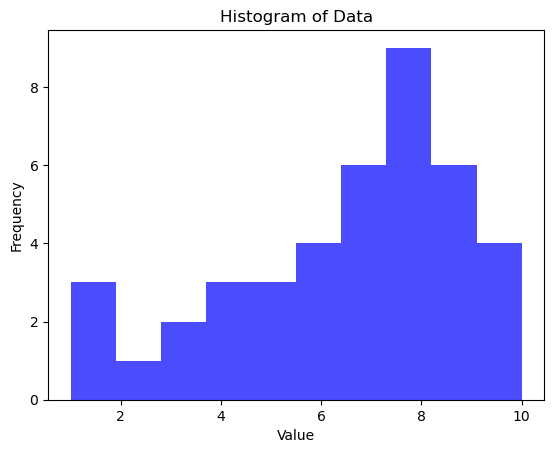

In [41]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(matched, bins=10, facecolor="blue", alpha=0.7)
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

<Axes: >

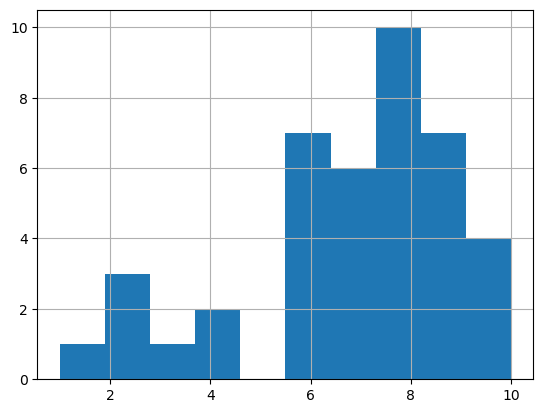

In [42]:
train_df.loc[train_df["user_id"] == user_id_list[0], "score"].hist(bins=10)

<Axes: >

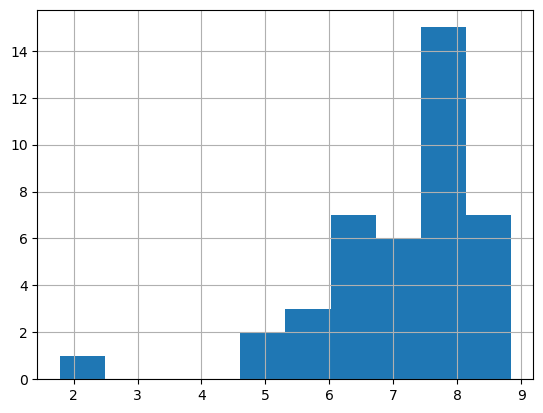

In [33]:
train_df.loc[train_df["user_id"] == user_id_list[0], "pred"].hist(bins=10)

<Axes: xlabel='anime_id', ylabel='error'>

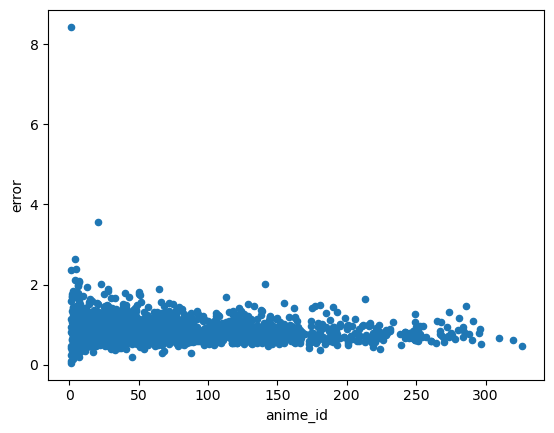

In [40]:
# 仮説：ユーザーごとにscoreの付け方が大きく違うのでは？

train_df.groupby("user_id").agg({"score": "var", "error": "mean", "anime_id": "count"}).plot.scatter(
    x="anime_id", y="error"
)

In [ ]:
# あるユーザー

<Axes: xlabel='pred', ylabel='error'>

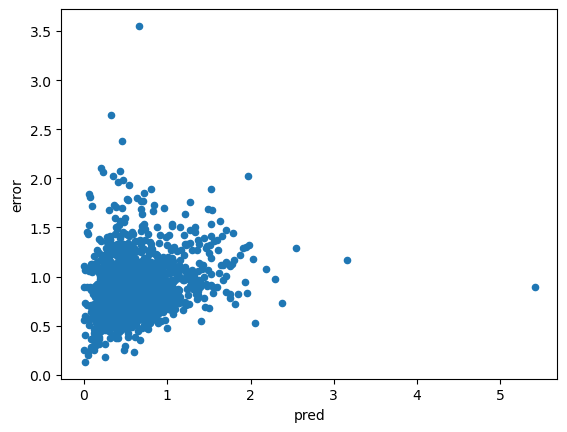

In [27]:
train_df.groupby("user_id").agg({"pred": "var", "error": "mean"}).plot.scatter(x="pred", y="error")

In [ ]:
# user ごとに、score の分布と同じになるように pred の分布を修正する

In [3]:
seen = ["100_lgb/a47bfbf2"]

NameError: name 'model_name' is not defined